<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/ResNet50%20final/WOTL%2050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers, models, optimizers
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.applications import ResNet50

# Evaluasi
#import torch
#import torchvision.models as models
#from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 94% 151M/161M [00:01<00:00, 106MB/s]
100% 161M/161M [00:01<00:00, 98.8MB/s]


In [5]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [6]:
dataset_dir = '/content/data'

In [7]:
print(os.listdir(dataset_dir))

['Blight', 'Healthy', 'Gray_Leaf_Spot', 'Common_Rust']


In [8]:
IMAGE_SIZE_resnet50 = 224

In [9]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_resnet50, IMAGE_SIZE_resnet50))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [10]:
X = []
Z = []

In [11]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:04<00:00, 248.99it/s]


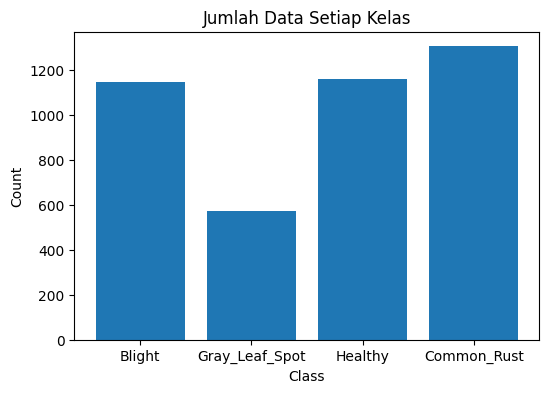

In [12]:
# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Jumlah Data Setiap Kelas')
plt.show()

In [13]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [27]:
# Ukuran input shape
IMAGE_SIZE_resnet50 = 224

# Fungsi identity block
def identity_block(X, f, filters, stage, block):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = layers.Conv2D(F1, (1, 1), strides=(1, 1), padding='valid',
                      name=conv_name_base + '2a',
                      kernel_initializer='he_normal')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(F2, (f, f), strides=(1, 1), padding='same',
                      name=conv_name_base + '2b',
                      kernel_initializer='he_normal')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(F3, (1, 1), strides=(1, 1), padding='valid',
                      name=conv_name_base + '2c',
                      kernel_initializer='he_normal')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X

# Fungsi convolutional block
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = layers.Conv2D(F1, (1, 1), strides=(s, s), padding='valid',
                      name=conv_name_base + '2a',
                      kernel_initializer='he_normal')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(F2, (f, f), strides=(1, 1), padding='same',
                      name=conv_name_base + '2b',
                      kernel_initializer='he_normal')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(F3, (1, 1), strides=(1, 1), padding='valid',
                      name=conv_name_base + '2c',
                      kernel_initializer='he_normal')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = layers.Conv2D(F3, (1, 1), strides=(s, s), padding='valid',
                               name=conv_name_base + '1',
                               kernel_initializer='he_normal')(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X

# Fungsi ResNet50
def ResNet50(input_shape=(224, 224, 3), classes=1000):
    X_input = layers.Input(input_shape)

    X = layers.ZeroPadding2D((3, 3))(X_input)

    X = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer='he_normal')(X)
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer='he_normal')(X)

    model = models.Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# Buat model ResNet50
model_resnet50 = ResNet50(input_shape=(IMAGE_SIZE_resnet50, IMAGE_SIZE_resnet50, 3), classes=4)

# Kompilasi model
model_resnet50.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model_resnet50.summary()

# Pastikan untuk mendefinisikan X_train dan Y_train sebelum melatih model
model_resnet50.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_5 (ZeroPadd  (None, 230, 230, 3)          0         ['input_6[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         9472      ['zero_padding2d_5[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1[0][0]']        

27/27 [==============================] - 4s 93ms/step


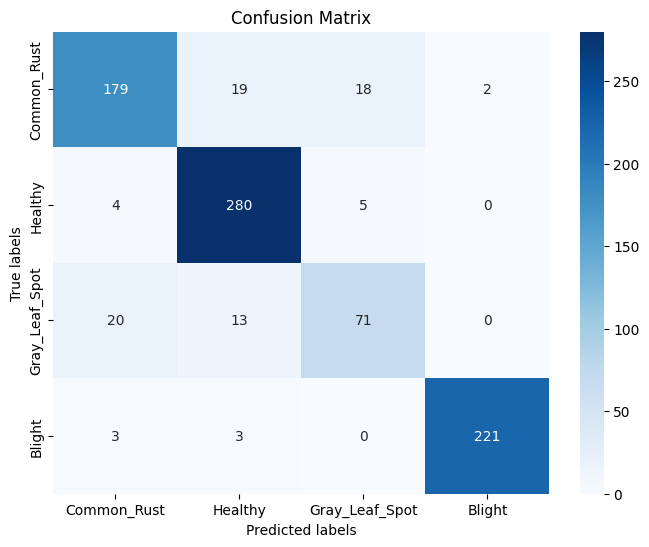


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       218
           1       0.89      0.97      0.93       289
           2       0.76      0.68      0.72       104
           3       0.99      0.97      0.98       227

    accuracy                           0.90       838
   macro avg       0.88      0.86      0.87       838
weighted avg       0.89      0.90      0.89       838



In [28]:
# Menggunakan model_resnet50ver2 untuk membuat prediksi pada data uji
Y_pred = model_resnet50.predict(X_test)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai prediksi
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai label sebenarnya
Y_true = np.argmax(Y_test, axis=1)

# Membuat confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Menampilkan confusion matrix dalam bentuk visualisasi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Membuat classification report
class_report = classification_report(Y_true, Y_pred_classes)

# Menampilkan classification report
print("\nClassification Report:")
print(class_report)

In [29]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=1):
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([batch_size] + [dim for dim in model.input.shape[1:]], model.input.dtype))

    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                          run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

# Calculate FLOPs
flops = get_flops(model_resnet50)
print(f"FLOPs: {flops}")

FLOPs: 7682566872
